In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2025-03-09 00:49:53.200249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 00:49:53.200582: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 00:49:53.202947: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-09 00:49:53.209103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741510193.218974  178928 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741510193.22

2.18.0


In [2]:
data_dir = 'dataset'
batch_size = 32
img_height = 512
img_width = 512

## Import dataset

In [3]:
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 96 files belonging to 4 classes.
Using 77 files for training.
Using 19 files for validation.


W0000 00:00:1741510194.417912  178928 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Explore the data

In [4]:
class_names = train_ds.class_names
print(class_names)

['eric', 'jonathan', 'minh', 'stephen']


2025-03-09 00:49:54.638933: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


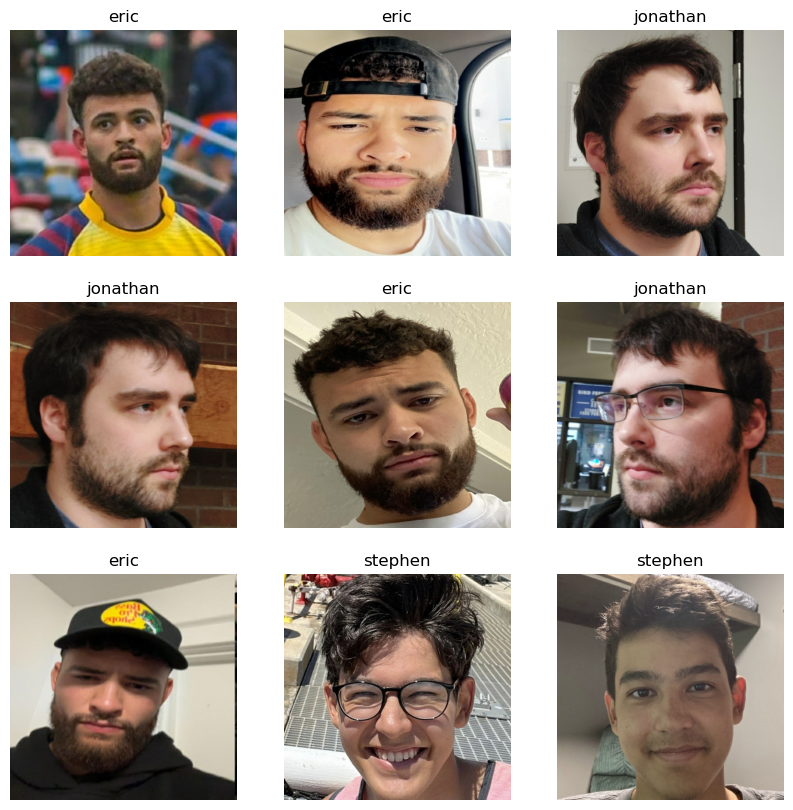

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 512, 3)
(32,)


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_images, train_labels = next(iter(normalized_train_ds))

normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_images, test_labels = next(iter(normalized_val_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


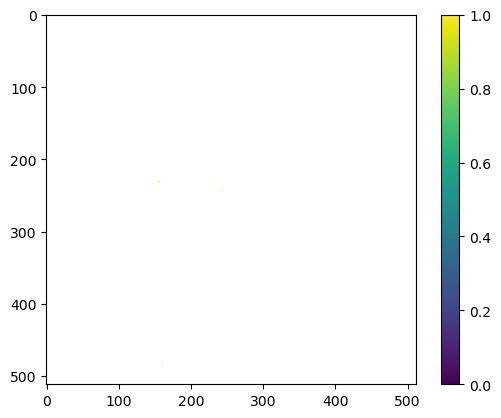

In [9]:
plt.figure()
plt.imshow(image_batch[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Build the model

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(512, 512, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

/home/laplace/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step - accuracy: 0.4062 - loss: 1.3471
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.2500 - loss: 508.7620
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.3125 - loss: 436.3274
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.2812 - loss: 720.1638
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.2500 - loss: 762.5775
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3750 - loss: 557.1394
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.4375 - loss: 361.4310
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.5312 - loss: 258.0664
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4062 - loss: 287.9120
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4688 - loss: 117.0020


In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - 92ms/step - accuracy: 0.5263 - loss: 105.7470

Test accuracy: 0.5263158082962036


In [14]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [15]:
predictions = probability_model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


In [16]:
predictions[0]

array([0., 0., 1., 0.], dtype=float32)

In [17]:
np.argmax(predictions[0])

2

In [18]:
test_labels[0]

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [19]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(len(class_names))
  plt.yticks([])
  thisplot = plt.bar(len(class_names), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

TypeError: object of type 'int' has no len()

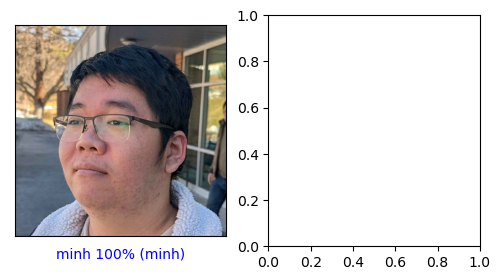

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [ ]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

In [ ]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()

In [ ]:
np.argmax(predictions_single[0])

In [ ]:
predictions